In [1]:
# TODO:
#  1 #  build smaller resnet 9
# 2. Relu6
# 1.5 Fix trainer [3/3]
# why features' weights small but not zero? Try again after relu6, should I try depth-separable conv?
# switch to my optimizer before deeper research
# manual livnet for cifar10, and then think on auto?
# interesting residual block two cases - put into and separate convs... does it needed at all, it is forced by connection...

%load_ext autoreload
%autoreload 2
import torch
import torch.utils
import torch.utils.data
import torchsummary
import numpy as np
import gc
from livenet.utils import set_seed
import onnx
import livenet
device = "cuda"
#device = "cpu"
#torch.set_default_device(device)
from ai_libs.simple_log import LOG



In [42]:
batch_size = 256
from livenet.datasets import TransformDataset
test_x, test_y = livenet.datasets.get_cifar10_test()
test = torch.utils.data.TensorDataset(test_x, test_y)
test_aug = TransformDataset(test, livenet.datasets.cifar10_test_transform)
test_loader = torch.utils.data.DataLoader(test_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=4, pin_memory=True)

train_x, train_y = livenet.datasets.get_cifar10_train()
train = torch.utils.data.TensorDataset(train_x, train_y)
train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)
train_loader = torch.utils.data.DataLoader(train_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=16, pin_memory=True, prefetch_factor=2)



In [110]:

#train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)


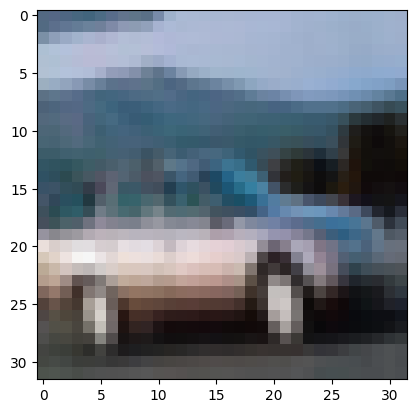

In [9]:
img = train_aug[4][0].numpy()
img = img.transpose(1, 2, 0)
from matplotlib import pyplot as plt
#img = livenet.datasets._elastic_transform(img, (-4, 0))
img = (img * 128 + 127).astype(np.uint8)
plt.imsave("/home/spometun/img.png", img)
plt.imshow( img )

In [3]:
from cifar_arch import EffNet, ResNet9

set_seed(0)

# network = EffNet(device)
network = ResNet9(3, 10, device)
torchsummary.summary(network, (3, 32, 32), device=device)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [43]:
# batch_iterator = livenet.gen_utils.batch_iterator(train_x, train_y, batch_size)
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
# epoch_size = len(train_x) // batch_size // 10
trainer = livenet.net_trainer.NetTrainer(network, train_loader, criterion, optimizer)
trainer.adaptive_lr = True
optimizer.learning_rate = 0.01



Torch


In [65]:
network.train()
#trainer._need_to_stop = False
trainer.optimizer.learning_rate = 0.01 / 2 / 2 / 2 /2/2/2/2/2/2/1.8
network._alpha = 5 * 1e-6
trainer.step(1000)


Iˈ0.000 0 0.992114544414185 0.9030679513246586 0.9102456529935201 <string>:18
Iˈ0.001 104334 0.525+0.378reg params=34 lr=0.00001 <string>:35
Iˈ20.788 0 1.003841068933363 0.9065366975772076 0.9030679513246586 <string>:18
Iˈ20.789 104529 0.529+0.378reg params=34 lr=0.00001 <string>:35
Iˈ41.481 1 1.0038445756845948 0.9100219465219057 0.9065366975772076 <string>:18
Iˈ41.482 104724 0.532+0.378reg params=34 lr=0.00001 <string>:35
Iˈ47.195 stopped livenet/net_trainer.py:58


In [41]:
tl = torch.utils.data.DataLoader(train_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=16, pin_memory=True, prefetch_factor=2)
for el in tl:
    pass


In [66]:
gc.collect()
torch.cuda.empty_cache()

def _infer_epoch(network, loader):
    preds = []
    ys = []
    with torch.no_grad():
        for x, y in iter(loader):
            x = x.to(network.device)
            pred = network(x)
            pred = pred.cpu()
            preds.append(pred)
            ys.append(y.cpu())
    pred = torch.concatenate(preds)
    y = torch.concatenate(ys)
    return pred, y


network.train()
#train_pred, train_labels = _infer_epoch(network, train_loader)
test_pred, test_labels = _infer_epoch(network, test_loader)

network.eval()
test_pred, test_labels = _infer_epoch(network, test_loader)
train_pred, train_labels = _infer_epoch(network, train_loader)

def calc_accuracy(predictions, labels):
    _, predicted = torch.max(predictions.data, 1)
    labels = labels.numpy()
    labels = np.squeeze(labels, 1)
    predicted = predicted.numpy()
    correct = np.sum(predicted == labels)
    total = len(labels)
    accuracy = correct / total
    return accuracy


# test_y_tensor = torch.tensor(test_y, device="cpu")
# train_y_tensor = torch.tensor(train_y, device="cpu")
test_loss = trainer.criterion(test_pred, test_labels).item()
train_loss = trainer.criterion(train_pred, train_labels).item()
LOG(f"loss: train: {train_loss:.3f} test: {test_loss:.3f}")

test_accuracy = calc_accuracy(test_pred, test_labels)
train_accuracy = calc_accuracy(train_pred, train_labels)
LOG(f"accuracy, train: {100 * train_accuracy:.1f}% test: {100 * test_accuracy:.1f}%")

Iˈ0.000 loss: train: 0.624 test: 0.534 
Iˈ0.001 accuracy, train: 85.0% test: 87.4% 


In [67]:
param = list(network.named_parameters())
param0 = list(network.parameters())


In [236]:
w = param[12][1].detach().cpu().numpy()
m = np.max(np.abs(w), axis=(1, 2, 3))
f"{int(100 * np.sum(m > 0.01) / len(m))}%"
np.sum(m > 0.01)

np.int64(12)

In [76]:
outs = dict()
for i in range(9):
    ind = i * 4
    w = param[ind][1].detach().cpu().numpy()
    if ind == 32:
        w = w[:, :, None, None]
    m_out = np.max(np.abs(w), axis=(1, 2, 3))
    outs[ind] = m_out > 0.01
    m_in = np.max(np.abs(w), axis=(0, 2, 3))
    n_out = np.sum(m_out > 0.01)
    n_in = np.sum(m_in > 0.01)
    s = f"{ind}, {w.shape} {int(100 * np.sum(m_out > 0.01) / len(m_out))}%, {n_in}->{n_out}"
    if ind in [12, 28]:
        n_inter = np.sum(outs[ind - 8] * outs[ind])
        s += f" inter={n_inter}"
    print(s)


0, (64, 3, 3, 3) 10%, 3->7
4, (128, 64, 3, 3) 10%, 7->13
8, (128, 128, 3, 3) 3%, 13->5
12, (128, 128, 3, 3) 3%, 5->4 inter=3
16, (256, 128, 3, 3) 10%, 14->26
20, (512, 256, 3, 3) 14%, 26->72
24, (512, 512, 3, 3) 17%, 72->88
28, (512, 512, 3, 3) 7%, 88->40 inter=10
32, (10, 512, 1, 1) 100%, 512->10


In [185]:
np.set_printoptions(1)
w = param[12][1].detach().cpu().numpy()
wa = np.abs(w)
wa_max = np.max(wa, axis=(1, 2, 3))
i = np.argsort(wa_max)[::-1]
f = w[i[0]]
fa = np.abs(f)
fa_max = np.max(fa, axis=(1, 2))
#print(f"{wa_max[i]}")
# print(wa[i].shape)
i1 = np.argsort(fa_max)[::-1]
f1b = fa > 0.1
np.sum(f1b)
f[i1[2]]
# fa[69]
#f[i1]

array([[ 1.4e-02,  5.9e-03,  1.4e-03],
       [-2.8e-05, -2.1e-01, -1.1e-04],
       [-6.2e-03, -4.6e-02,  2.4e-02]], dtype=float32)